# Collaboration and Competition

---

Solution for project 3 of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### Packages

Import the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch

import time
from collections import deque

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from agent.maddpg import MADDPG, MultiAgentConfig

### Unity Environment

A wrapper for the unity environment making it resemble an [OpenAI Gym Environment](https://gym.openai.com/).

In [3]:
class EnvironmentWrapper(object):    
    """Wrapper to make the unity enviroment more like OpenAI Gym."""
    
    def __init__(self, env):
        """Initialize.
        
        Params
        ======
            env: The unity environment to wrap.
        """
        self.env = env
        self.brain_name = self.env.brain_names[0]

        self.env_info = self.env.reset(train_mode=True)[self.brain_name]
        self.num_agents = len(self.env_info.agents)
        
        self.action_size = self.env.brains[self.brain_name].vector_action_space_size
        self.state_size = len(self.env_info.vector_observations[0])
        
        self.actions = np.zeros((self.num_agents, self.action_size))
        
    def reset(self, train_mode=True):
        env_info = self.env.reset(train_mode=train_mode)[self.brain_name]
        return env_info.vector_observations
    
    def step_single(self, action, agent):
        self.actions[agent] = action

        env_info = self.env.step(self.actions)[self.brain_name] 
        reward = env_info.rewards[agent]
        next_state = env_info.vector_observations[agent]
        done = env_info.local_done[agent]
        
        return next_state, reward, done, env_info
    
    
    def step(self, action):
        env_info = self.env.step(action)[self.brain_name] 
        reward = env_info.rewards
        next_state = env_info.vector_observations
        done = env_info.local_done
        
        return next_state, reward, done, env_info

Start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [4]:
env = UnityEnvironment(file_name="./environments/Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Wrap up the tennis environment in a gym-like container.

In [5]:
tennis_env = EnvironmentWrapper(env)

### MADDPG Agent Training

The training harness for the agent using [Multi-Agent Deep Deterministic Policy Gradients](https://arxiv.org/pdf/1706.02275.pdf).

In [6]:
def maddpg(maddpg_agent, n_episodes=500, max_t=1000, print_every=100):
    
    scores = []
    scores_window = deque(maxlen=100)
    frame_num = 0
    current_max = 1.0
        
    for i_ep in range(1, n_episodes + 1):
        state = tennis_env.reset(True)
        maddpg_agent.reset()
        
        agent_scores = np.zeros(tennis_env.num_agents)
        
        for t in range(max_t):
            action = maddpg_agent.act(state, 1.0)
                        
            next_state, reward, done, _ = tennis_env.step(action)
            
            maddpg_agent.step(state, action, reward, next_state, done)
            
            state = next_state
            agent_scores += reward

            frame_num += 1
            
            if np.any(done):
                break
        
        max_score = np.max(agent_scores)
        scores_window.append(max_score)
        scores.append(max_score)
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_ep, np.mean(scores_window)), end="")
        
        if i_ep % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_ep, np.mean(scores_window)))

        if max_score > current_max:
            ddpg_agent.save_checkpoints('checkpoints/checkpoint_max_')
            current_max = max_score
            
        if np.mean(scores_window) >= 0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_ep, np.mean(scores_window)))
            break
            
            
    return scores

Utility to plot the scores.

In [7]:
def plot_scores(scores, title=""):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.title(title)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

### Random Replay

Training the agent with optimized hand-tuned hyperparameters. This agent uses a random access experience replay buffer.

Randomized Replay Buffer
Agent Config:
	buffer size: 100000	batch size: 512
	gamma: 0.99	tau: 0.2
	actor lr: 0.0001	critic lr: 0.0003
	mu: 0.0	theta: 0.15	sigma: 0.2
Episode 100	Average Score: 0.00
Episode 200	Average Score: 0.00
Episode 300	Average Score: 0.01
Episode 400	Average Score: 0.04
Episode 500	Average Score: 0.02
Episode 600	Average Score: 0.01
Episode 700	Average Score: 0.06
Episode 800	Average Score: 0.08
Episode 900	Average Score: 0.09
Episode 1000	Average Score: 0.09
Episode 1100	Average Score: 0.11
Episode 1200	Average Score: 0.07
Episode 1300	Average Score: 0.13
Episode 1400	Average Score: 0.22
Episode 1500	Average Score: 0.21
Episode 1600	Average Score: 0.25
Episode 1700	Average Score: 0.45
Episode 1717	Average Score: 0.50
Environment solved in 1717 episodes!	Average Score: 0.50
Training took 1126.23 seconds


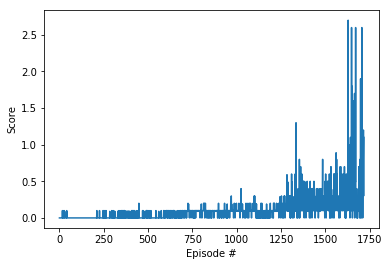

In [10]:
config = MultiAgentConfig()
config.prioritized_replay = False

print("Randomized Replay Buffer")
print(config)

start_time = time.time()
ddpg_agent = MADDPG(tennis_env.state_size, tennis_env.action_size, config)
scores = maddpg(ddpg_agent, 3000, 2000)
print("Training took {:.2f} seconds".format(time.time() - start_time))

plot_scores(scores)

# save the checkpoints
ddpg_agent.save_checkpoints('checkpoints/checkpoint_random_')

### Prioritized Replay

Training the agent with the hyperparameters from above. This agent uses a prioritized experience replay buffer using the strategy outlined in [this paper](https://ieeexplore.ieee.org/document/8122622).

Prioritized Replay Enabled
Agent Config:
	buffer size: 100000	batch size: 512
	gamma: 0.99	tau: 0.2
	actor lr: 0.0001	critic lr: 0.0003
	mu: 0.0	theta: 0.15	sigma: 0.2
Episode 100	Average Score: 0.01
Episode 200	Average Score: 0.01
Episode 300	Average Score: 0.02
Episode 400	Average Score: 0.02
Episode 500	Average Score: 0.05
Episode 600	Average Score: 0.11
Episode 700	Average Score: 0.19
Episode 800	Average Score: 0.12
Episode 900	Average Score: 0.23
Episode 1000	Average Score: 0.28
Episode 1100	Average Score: 0.42
Episode 1182	Average Score: 0.51
Environment solved in 1182 episodes!	Average Score: 0.51
Training took 1225.49 seconds


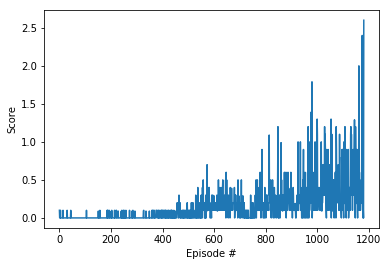

In [10]:
# train the agent for 500 episodes and show the scores
config = MultiAgentConfig()
config.prioritized_replay = True
config.beta_decay = 20000

print("Prioritized Replay Enabled")
print(config)

start_time = time.time()
ddpg_agent = MADDPG(tennis_env.state_size, tennis_env.action_size, config)
scores = maddpg(ddpg_agent, 3000, 2000)
print("Training took {:.2f} seconds".format(time.time() - start_time))

plot_scores(scores)

# save the checkpoints
ddpg_agent.save_checkpoints('checkpoints/checkpoint_per_')

### Watch a Smart Agent

Watch an agent control two paddles to try to keep the ball aloft.

In [8]:
def run_smart_agent(agent):
    for i in range(0, 3): 
        state = tennis_env.reset(False)
        score = np.zeros(tennis_env.num_agents)
        while True:
            action = agent.act(state, 0.0)
            next_state, reward, done, _ = tennis_env.step(action)
            score += reward                               # update the score
            state = next_state                             # roll over the state to next time step
            if any(done):                                       # exit loop if episode finished
                break
        print("Max Score: {}".format(np.max(score)))

In [9]:
config = MultiAgentConfig()
config.buffer_size = int(1e5)
config.batch_size = 512
config.gamma = 0.99
config.lr_actor = 1e-4
config.lr_critic = 3e-4
config.actor_hidden_sizes = [256, 128]
config.critic_hidden_sizes = [256, 128]

ddpg_agent = MADDPG(tennis_env.state_size, tennis_env.action_size, config)
ddpg_agent.load_checkpoints('checkpoints/checkpoint_max_')
run_smart_agent(ddpg_agent)

Max Score: 0.20000000298023224
Max Score: 2.600000038743019
Max Score: 0.0


In [10]:
tennis_env.env.close()